In [2]:
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Set the audio filename - update this to your actual filename
audio_file = "Kokeilu_1.wav"

# pip install transformers
# pip install librosa
# pip install ipywidgets
# pip install PySoundFile
# conda install -c conda-forge libsndfile
# pip install sentencepiece
# pip install sacremoses

In [3]:
# Load audio file
y, sr = librosa.load(audio_file, sr=16000)

# Display audio for playback
print("Play the audio:")
display(Audio(y, rate=sr))

# Print audio statistics
duration = librosa.get_duration(y=y, sr=sr)
print(f"\nAudio Statistics:")
print(f"Duration: {duration:.2f} seconds")
print(f"Sample rate: {sr} Hz")

Play the audio:



Audio Statistics:
Duration: 9.77 seconds
Sample rate: 16000 Hz


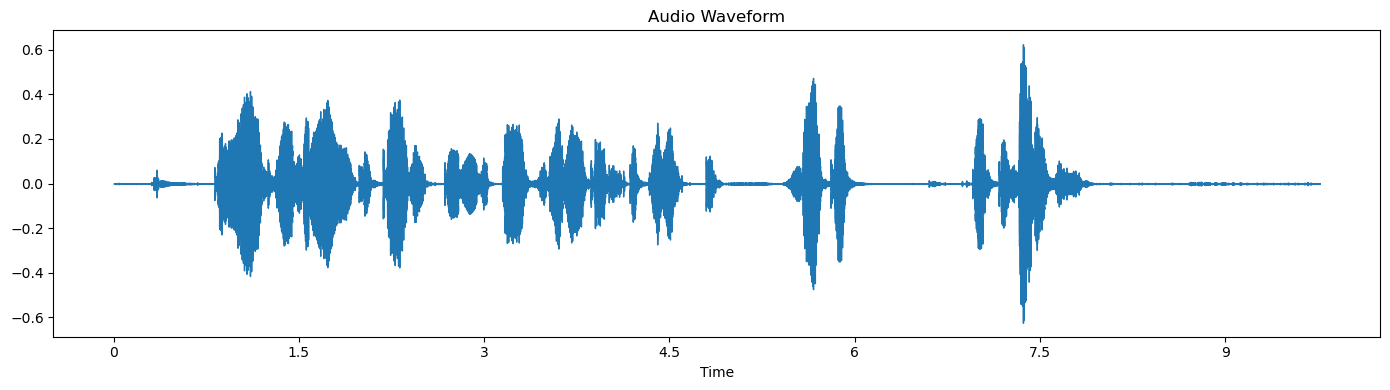

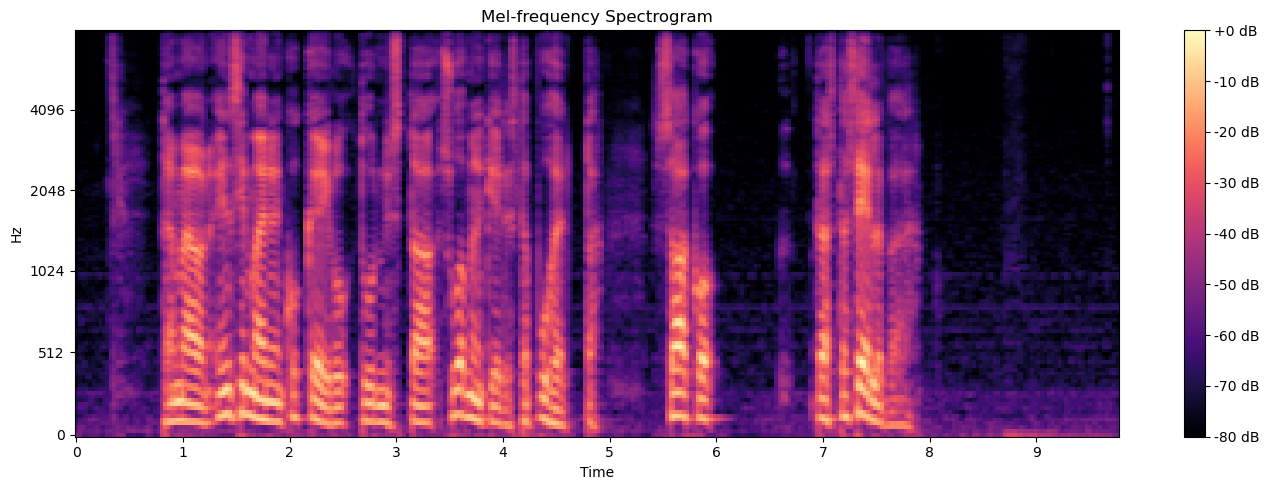

In [4]:
# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.tight_layout()
plt.show()

# Create mel spectrogram
plt.figure(figsize=(14, 5))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, y_axis='mel', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency Spectrogram')
plt.tight_layout()
plt.show()

In [5]:
# Initialize the model
model_size = "large"  # Options: tiny, base, small, medium, large
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Load model and processor
print(f"Loading Whisper {model_size} model...")
model_name = f"openai/whisper-{model_size}"
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

# Set the language to Finnish
forced_decoder_ids = processor.get_decoder_prompt_ids(language="fi", task="transcribe")

# Process with WhisperProcessor
print("Processing audio...")
input_features = processor(
    y, 
    sampling_rate=sr, 
    return_tensors="pt"
).input_features.to(device)

# Generate the transcription
print("Generating transcription...")
with torch.no_grad():
    generated_ids = model.generate(
        input_features,
        forced_decoder_ids=forced_decoder_ids
    )

# Decode the generated IDs
transcription = processor.batch_decode(
    generated_ids, 
    skip_special_tokens=True
)[0]

print("\nFINNISH TRANSCRIPTION:")
print("="*50)
print(transcription)

Using device: mps
Loading Whisper large model...


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.


Processing audio...
Generating transcription...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



FINNISH TRANSCRIPTION:
 Tämä on ensimmäinen kokeilu tunnistaa suomenkielistä puhetta. Saako tästä selvää?


In [6]:
# Set the task to translate
forced_decoder_ids_translate = processor.get_decoder_prompt_ids(language="fi", task="translate")

# Generate the translation
print("Generating English translation...")
with torch.no_grad():
    generated_ids = model.generate(
        input_features,
        forced_decoder_ids=forced_decoder_ids_translate
    )

# Decode the generated IDs
translation = processor.batch_decode(
    generated_ids, 
    skip_special_tokens=True
)[0]

print("\nENGLISH TRANSLATION:")
print("="*50)
print(translation)

Generating English translation...

ENGLISH TRANSLATION:
 This is the first time I have heard a Finnish-speaking person. Will I be able to understand this?


In [7]:
from transformers import MarianMTModel, MarianTokenizer

# Load a dedicated Finnish to English translation model
model_name = "Helsinki-NLP/opus-mt-fi-en"
translation_tokenizer = MarianTokenizer.from_pretrained(model_name)
translation_model = MarianMTModel.from_pretrained(model_name)

# Translate the Finnish transcription
inputs = translation_tokenizer(transcription, return_tensors="pt")
translated = translation_model.generate(**inputs)
better_translation = translation_tokenizer.decode(translated[0], skip_special_tokens=True)

print("BETTER ENGLISH TRANSLATION:")
print("="*50)
print(better_translation)

BETTER ENGLISH TRANSLATION:
This is the first experiment to identify Finnish speaking. Can you understand this?
